Kaggle Competition: Classify Mobile Users
-----------------------------------------------

This is an analysis for the [TalkingData Mobile User Demographics](https://www.kaggle.com/c/talkingdata-mobile-user-demographics) Kaggle competition. The competition was already closed when I started this, but I went through it for practice. I got a score of 2.29, which, if I had been able to join the leaderboard, would have been at position 1028 out of 1689; a decent enough score for a simple approach.

From the discussion board of the competition, it seems like many people used `xgboost` for this challenge, but I've done a competition with `xgboost` before, so I'll try something else: logistic regression. This was not so trivial, because I quickly ran out of memory to store my one-hot encoded features. Full credit goes to the person who made [this beautiful kernel](https://www.kaggle.com/dvasyukova/a-linear-model-on-apps-and-labels) available for teaching me how to get around that.

The challenge is to classify the users of mobile devices into several age categories, and also into whether they are male or female. The data on which to base the classification consists of the type of phone they have and what apps they use. Some additional information is available, but I'll focus on those pieces of information.

The apps someone uses probably says a lot about who they are: do they play a lot of games on their phone or not, for instance? That's why I'll start with the apps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Classifying based on apps installed

The data in `events.csv` gives us a list of events happening on different devices. The file `app_events` tells us what this event means: the ID of the corresponding app, and whether at that event the app is installed and active. The `is_installed` column is always 1, so if an app is present in this list, it is installed on the device.

Let's use this to build our first set of features: the apps that a device has installed. We'll load up the data and merge the two datafiles into the format we want to use.

In [2]:
# Load files; only the columns we care about
events = pd.read_csv('input/events.csv', usecols = ['event_id', 'device_id'])
app_events = pd.read_csv('input/app_events.csv', usecols = ['event_id', 'app_id'])


device_apps = (
    app_events
    
     # Merge on event_id
    .merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id')
    
     # event_id itself is not interesting
    .drop('event_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates()
)

# Our data now looks like this
device_apps.head()

,app_id,device_id
0,5927333115845830913,-6401643145415154744
1,-5720078949152207372,-6401643145415154744
2,-1633887856876571208,-6401643145415154744
3,-653184325010919369,-6401643145415154744
4,8693964245073640147,-6401643145415154744


In order to perform logistic regression, we need to one-hot encode our apps. Unfortunately there are just too many of them:

In [3]:
# Too many apps. 
device_apps['app_id'].value_counts().size

19237

A naive call to pd.get_dummies() quickly results in a memory error. My machine, at least, is not able to deal with creating so many dummies.

However, for any given device, almost certainly only a very small subset of apps is installed. We can therefore encode our dummy variables in a sparse matrix. To do so, we will use `csr_matrix` from `scipy`, which stores the data in [Compressed Sparse Row](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29) format. To do so, we need to give it the non-zero values in the matrix (i.e. all the 1s for the apps a given device has installed), and the row and column indices where they are supposed to go.

We want to end up with a matrix whose rows are the devices listed in the `gender_age_train.csv` or `gender_age_test.csv` files. Therefore we will load up the appropriate file (we'll start with the training set) and number its rows.

In [4]:
# Load up the training data
gender_age_train = pd.read_csv('input/gender_age_train.csv')

# Numbers its rows in a new column
gender_age_train['rownum'] = gender_age_train.index

# We now have this 
gender_age_train.head()

,device_id,gender,age,group,rownum
0,-8076087639492063270,M,35,M32-38,0
1,-2897161552818060146,M,35,M32-38,1
2,-8260683887967679142,M,35,M32-38,2
3,-4938849341048082022,M,30,M29-31,3
4,245133531816851882,M,30,M29-31,4


The columns of our feature matrix should represent the different apps, one column each. To assign consecutive numbers to the apps, we can use `sklearn`'s `LabelEncoder`:

In [5]:
# Build numerical labels for our apps
appencoder = LabelEncoder().fit(device_apps.app_id)

# Store in a new column
device_apps['app'] = appencoder.transform(device_apps.app_id)

# Combining with our row numbers
sparse_encoding_apps = (
    device_apps[['device_id', 'app']]
    
    # Grab rownum
    .merge(gender_age_train[['device_id','rownum']], how = 'left', left_on = 'device_id', right_on = 'device_id')
    
    # Some devices are not in the training set
    .dropna()
)

# We now have a dataframe encoding all the locations where
# our sparse matrix should have a 1 instead of a 0.
sparse_encoding_apps.head()

,device_id,app,rownum
19,1476664663289716375,1819,51154.0
20,1476664663289716375,15784,51154.0
21,1476664663289716375,15408,51154.0
22,1476664663289716375,13094,51154.0
23,1476664663289716375,5733,51154.0


Using the dataframe we just created, we can now build our sparse matrix. Using `csr_matrix( (data, (row_indices, column_indices) ) )`, build it as follows.

In [6]:
# Building our sparse feature matrix
sparse_app_matrix = (
    csr_matrix(
        (
            # We need as many 1s as there are
            # rows in our training set
            np.ones(sparse_encoding_apps.shape[0]), 
            
            # The rownum and app columns give
            # us the indices at which to place
            # the 1s
            (
                sparse_encoding_apps['rownum'], 
                sparse_encoding_apps['app']
            )
        )
    )
)

Our data structure is of course hard to inspect now, but we can look at aggregate quantities. Let's try to get a feel for what our data looks like.

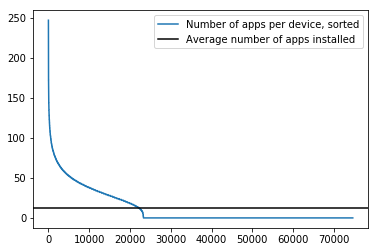

In [7]:
# Let's plot the number of apps that each device
# has installed
plt.plot(
    range(sparse_app_matrix.shape[0]),
    np.sort(np.asarray(sparse_app_matrix.sum(axis=1)).flatten())[::-1],
    label = 'Number of apps per device, sorted'
)
plt.axhline(
    sparse_app_matrix.sum(axis=1).mean(), 
    color = 'black', 
    label = 'Average number of apps installed'
)
plt.legend()
plt.show()

In the plot above we see that many devices actually don't have apps installed, as far as we know. Unfortunately, that will hamper our ability to classify them. Perhaps other parts of the data set will help us with those, but for now we simply take note of this limitation.

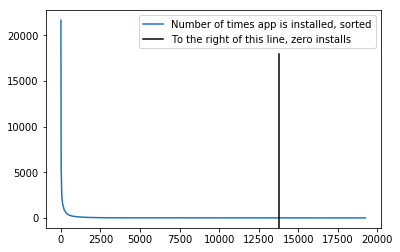

In [8]:
# Let's plot the number of times the apps are
# installed on devices
plt.gcf().clear()
plt.plot(
    range(sparse_app_matrix.shape[1]),
    np.sort(np.asarray(sparse_app_matrix.sum(axis=0)).flatten())[::-1],
    label = 'Number of times app is installed, sorted'
)
plt.axvline(
    np.where(np.sort(np.asarray(sparse_app_matrix.sum(axis=0)).flatten())[::-1]==0)[0][0], 
    0,
    0.8,
    color = 'black',
    label = 'To the right of this line, zero installs'
)
plt.legend()
plt.show()

The second plot shows that most apps are not used very much. Some don't appear at all. This means the features corresponding to these apps will not be very useful. In the case of apps that are not installed on any devices, we might as well throw these features away. However, we will trust regularization to appropriately pick the important features.

Now that we have our sparse feature data, we can fit our logistic regression. Considering that there are features we expect to be useless, we might prefer to do a lasso regression. Unfortunately, scikit-learn doesn't currently provide support for multinomial lasso regression, and we will use ridge regression instead.

We need to choose the regularization coefficient for our fit, for which we'll use cross validation.

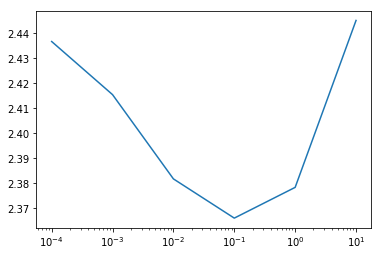

In [9]:
# Set up the targets
target = gender_age_train['group'].values

# Set up our classifier
logreg_cv = LogisticRegressionCV(
    # Values to try for regularization
    Cs = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    
    # Lasso not available
    penalty = 'l2',        
    
    # We need probabilities
    multi_class = 'multinomial', 
    
    # This solver seems to be fastest
    solver = 'lbfgs',
    
    # Give it some time
    max_iter = 1000,
    
    # CV folds
    cv = 5,
    
    # Paralellized for 6-core machine
    n_jobs = 6,
    
    # We want the log-loss score
    scoring = 'neg_log_loss'
)

# Fit to our data
logreg_cv.fit(sparse_app_matrix, target)

# Plot the results
plt.plot([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], -logreg_cv.scores_.popitem()[1].mean(axis = 0))
plt.xscale("log")
plt.show()

We see that the optimal value for the regularization is around 0.01, and we're reaching a score of around 2.4, which is on the low end of the Kaggle leaderboard. We can look at a finer grid around 0.01 and optimize a bit further, allowing us to dip below 2.39.

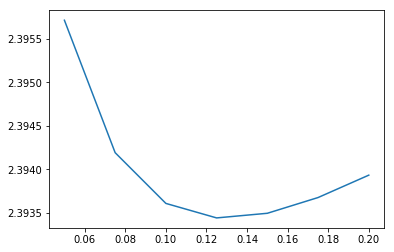

In [10]:
logreg_cv = LogisticRegressionCV(
    Cs = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2],
    penalty = 'l2', 
    multi_class = 'multinomial',
    solver = 'lbfgs',
    fit_intercept = False,
    max_iter = 1000,
    cv = 5,
    n_jobs = 6,
    scoring = 'neg_log_loss'
)
logreg_cv.fit(sparse_app_matrix, target)
plt.plot([0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2], -logreg_cv.scores_.popitem()[1].mean(axis = 0))
plt.show()

# Adding phone brands and models

Classifying users based on their apps seems to work quite well, but let's see if we can improve our score by including another part of the data set. Users in different categories may also prefer different brands and models of phones, so this may add some predictive power. The file `phone_brand_device_model.csv` contains for each device the brand and model:

In [11]:
phones = pd.read_csv('input/phone_brand_device_model.csv')
phones.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


We now want to create a feature matrix just as we did for the apps. We now have two columns, brand and model. The brands may be expected to be a good predictor, so we'll start with those.

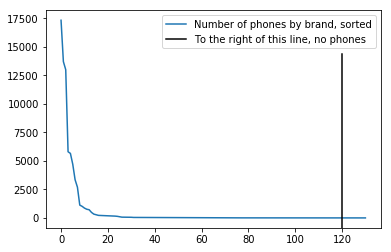

In [12]:
# Build numerical labels for our brands
brandencoder = LabelEncoder().fit(phones['phone_brand'])

# Store in a new column
phones['brand'] = brandencoder.transform(phones['phone_brand'])

# Combining with our row numbers
sparse_encoding_brands = (
    phones[['device_id', 'brand']]
    
    # Grab the rownum
    .merge(gender_age_train[['device_id','rownum']], how = 'left', left_on = 'device_id', right_on = 'device_id')
    
    # Some devices are not in the training set
    .dropna()
)

# Building our sparse feature matrix
sparse_brand_matrix = (
    csr_matrix(
        (
            # We need as many 1s as there are
            # rows in our training set
            np.ones(sparse_encoding_brands.shape[0]), 
            
            # The rownum and app columns give
            # us the indices at which to place
            # the 1s
            (
                sparse_encoding_brands['rownum'], 
                sparse_encoding_brands['brand']
            )
        )
    )
)

# Let's plot the number of times a brand
# occurs
plt.gcf().clear()
plt.plot(
    range(sparse_brand_matrix.shape[1]),
    np.sort(np.asarray(sparse_brand_matrix.sum(axis=0)).flatten())[::-1],
    label = 'Number of phones by brand, sorted'
)
plt.axvline(
    np.where(np.sort(np.asarray(sparse_brand_matrix.sum(axis=0)).flatten())[::-1]==0)[0][0], 
    0,
    0.8,
    color = 'black',
    label = 'To the right of this line, no phones'
)
plt.legend()
plt.show()

Above, we've simply replicated the procedure we used for the apps to build a new sparse matrix. The plot shows the number of times the brands occur in the dataset, and we see again that many brands are not very prevalent, meaning these features are probably not very useful, and regularization is also important here.

We can now combine our new features with the app features and create a new classifier.

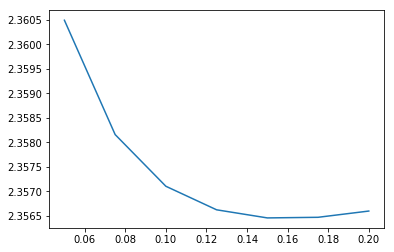

In [13]:
logreg_cv = LogisticRegressionCV(
    Cs = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2],
    penalty = 'l2', 
    multi_class = 'multinomial',
    solver = 'lbfgs',
    fit_intercept = False,
    max_iter = 1000,
    cv = 5,
    n_jobs = 6,
    scoring = 'neg_log_loss'
)
logreg_cv.fit(hstack([sparse_app_matrix, sparse_brand_matrix]), target)
plt.plot([0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2], -logreg_cv.scores_.popitem()[1].mean(axis = 0))
plt.show()

The optimal value for the regularization has shifted a little, but more importantly, our score has greatly improved to about 2.36. What happens if we also add the phone models?

The models require a little bit of preprocessing, because different brands seem to use the same model names sometimes.

In [14]:
print('Number of distinct model names: ' + str(phones.groupby(['device_model']).size().shape[0]))
print('Number of distinct brand+model names: ' + str(phones.groupby(['phone_brand','device_model']).size().shape[0]))

Number of distinct model names: 1599
Number of distinct brand+model names: 1667


That means we will have to combine the two columns into one, before building our features.

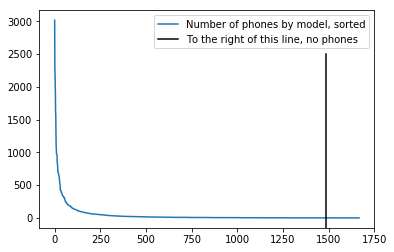

In [15]:
# Combine the two columns
phones['brand_and_model'] = phones['phone_brand'].astype(str) + phones['device_model']

# Build numerical labels for our models
modelencoder = LabelEncoder().fit(phones['brand_and_model'])

# Store in a new column
phones['model'] = modelencoder.transform(phones['brand_and_model'])

# Combining with our row numbers
sparse_encoding_models = (
    phones[['device_id', 'model']]
    
    # Grab the rownum
    .merge(gender_age_train[['device_id','rownum']], how = 'left', left_on = 'device_id', right_on = 'device_id')
    
    # Some devices are not in the training set
    .dropna()
)

# Building our sparse feature matrix
sparse_model_matrix = (
    csr_matrix(
        (
            # We need as many 1s as there are
            # rows in our training set
            np.ones(sparse_encoding_models.shape[0]), 
            
            # The rownum and app columns give
            # us the indices at which to place
            # the 1s
            (
                sparse_encoding_models['rownum'], 
                sparse_encoding_models['model']
            )
        )
    )
)

# Let's plot the number of times a brand
# occurs
plt.gcf().clear()
plt.plot(
    range(sparse_model_matrix.shape[1]),
    np.sort(np.asarray(sparse_model_matrix.sum(axis=0)).flatten())[::-1],
    label = 'Number of phones by model, sorted'
)
plt.axvline(
    np.where(np.sort(np.asarray(sparse_model_matrix.sum(axis=0)).flatten())[::-1]==0)[0][0], 
    0,
    0.8,
    color = 'black',
    label = 'To the right of this line, no phones'
)
plt.legend()
plt.show()

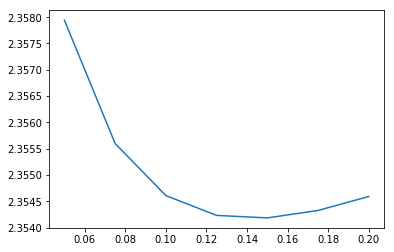

In [16]:
logreg_cv = LogisticRegressionCV(
    Cs = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2],
    penalty = 'l2', 
    multi_class = 'multinomial',
    solver = 'lbfgs',
    fit_intercept = False,
    max_iter = 1000,
    cv = 5,
    n_jobs = 6,
    scoring = 'neg_log_loss'
)
logreg_cv.fit(hstack([sparse_app_matrix, sparse_brand_matrix, sparse_model_matrix]), target)
plt.plot([0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2], -logreg_cv.scores_.popitem()[1].mean(axis = 0))
plt.show()

Adding the models has given us a small improvement, but not as substantial as the brands.

Now we're ready to predict on the test set. We have to build sparse features for the test data as well, which works the same as before.

In [19]:
# Load in the data
gender_age_test = pd.read_csv('input/gender_age_test.csv')
gender_age_test['rownum'] = gender_age_test.index

# Generate sparse feature matrices

sparse_encoding_test_apps = (
    device_apps[['device_id', 'app']]    
    .merge(gender_age_test[['device_id','rownum']], how = 'left', left_on = 'device_id', right_on = 'device_id')    
    .dropna()
)

sparse_app_test_matrix = (
    csr_matrix(
        (
            np.ones(sparse_encoding_test_apps.shape[0]),             
            (
                sparse_encoding_test_apps['rownum'], 
                sparse_encoding_test_apps['app']
            )
        ),
        shape = (gender_age_test.shape[0], appencoder.classes_.size)
    )
)

sparse_encoding_test_brands = (
    phones[['device_id', 'brand']]    
    .merge(gender_age_test[['device_id','rownum']], how = 'left', left_on = 'device_id', right_on = 'device_id')    
    .dropna()
)

sparse_brand_test_matrix = (
    csr_matrix(
        (
            np.ones(sparse_encoding_test_brands.shape[0]),             
            (
                sparse_encoding_test_brands['rownum'], 
                sparse_encoding_test_brands['brand']
            )
        ),
        shape = (gender_age_test.shape[0], brandencoder.classes_.size)
    )
)

sparse_encoding_test_models = (
    phones[['device_id', 'model']]    
    .merge(gender_age_test[['device_id','rownum']], how = 'left', left_on = 'device_id', right_on = 'device_id')    
    .dropna()
)

sparse_model_test_matrix = (
    csr_matrix(
        (
            np.ones(sparse_encoding_test_models.shape[0]), 
            
            (
                sparse_encoding_test_models['rownum'], 
                sparse_encoding_test_models['model']
            )
        ),
        shape = (gender_age_test.shape[0], modelencoder.classes_.size)
    )
)

sparse_test_matrix = hstack(
    [
        sparse_app_test_matrix, 
        sparse_brand_test_matrix, 
        sparse_model_test_matrix
    ]
)

sparse_train_matrix = hstack(
    [
        sparse_app_matrix, 
        sparse_brand_matrix, 
        sparse_model_matrix
    ]
)

# Fit logistic regression

logreg = LogisticRegression(
    C = 0.15,
    penalty = 'l2', 
    multi_class = 'multinomial',
    solver = 'lbfgs',
    fit_intercept = False,
    max_iter = 1000,
    n_jobs = 6,
)

logreg.fit(
    sparse_train_matrix, 
    target
);

In [18]:
# Generate prediction
pred = pd.DataFrame(logreg.predict_proba(sparse_test_matrix))

# Rename the columns to the classes
pred.columns = logreg.classes_

# Add device_id column
pred.insert(0, 'device_id', gender_age_test['device_id'])

# Save
pred.to_csv('output/submission.csv', index = False)

# Quick look
pred.head()

,device_id,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
0,1002079943728939269,0.000281,0.002943,0.016022,0.006342,0.083250,0.042505,0.005963,0.028700,0.047145,0.112938,0.325913,0.327998
1,-1547860181818787117,0.019392,0.020178,0.020385,0.037651,0.053464,0.072346,0.005471,0.106510,0.155289,0.076740,0.203469,0.229104
2,7374582448058474277,0.017118,0.024718,0.020569,0.168225,0.146595,0.059321,0.024701,0.046026,0.076444,0.077444,0.187997,0.150844
3,-6220210354783429585,0.001461,0.013365,0.003832,0.017157,0.053270,0.130423,0.072654,0.175614,0.133862,0.083067,0.111116,0.204178
4,-5893464122623104785,0.035689,0.076453,0.041487,0.064746,0.049523,0.035591,0.071675,0.174221,0.111159,0.104379,0.142464,0.092615


Above, we fitted the model on the training set, using the regularization coefficient we found through cross validation. The Kaggle competition was already closed at time of writing, but I generated a submission anyway, which scored 2.29; a reasonable score on the leaderboard for a relatively simple model!